<img src="parental_advisory.png" alt="Drawing" style="width: 400px;"/>

# This notebook uses topic modeling on rap lyrics to that we can investigate differences between East Coast and West Coast rap and its legendary rivalry.  Additionally, we will ask whether any differences in gender between Male and Female rappers who were a part of this rivalry.  The objective here is not the rivalry or the regrettable violence and unfortunate lives lost but rather what we can learn about differences in styles, themes and word choice

<img src="2pac_biggie.png" style="width:400px" />
<p>Image Source : 2paclegacy.net</p>

# To perform our analysis, we'll be using a common technique called Latent Dirichlet Allocation (LDA) to help us find topics and their associated terms in documents in an unsupervised method
### What is LDA?  The short answer is that LDA is a mixture model where the underlying premise is that each document is a mixture of topics and that these topics are made up of terms and/or phrases
### Background : The LDA algorithm was proposed in 2003 by David Blei with [this paper](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf).  You can also read more about it here on [Wikipedia](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation).
### If you're satisfied with this high level description for now, feel free to move on to the analysis or go ahead and watch the 9 minute video below which gives a better intuition for these topic models and how they are defined

In [1]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/DWJYZq_fQ2A"' \
     'frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>')

# Now that our objectives are clear, let's start importing some packages to get started...

In [2]:
# common Python imports
import sys
import os
import re
from collections import defaultdict
import pickle
import datetime

In [3]:
# enable inline plotting in our notebook
import matplotlib.pyplot as plt
from IPython.display import display

%matplotlib inline

In [4]:
# these are used for NLP, Data Manipulation, etc
import gensim
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import pyLDAvis
from pyLDAvis.gensim import prepare as gensim_prepare

# prepare to do interactive visualizations within the notebook:
pyLDAvis.enable_notebook()

print('numpy version : {}'.format(np.__version__))
print('gensim version : {}'.format(gensim.__version__))
print('nltk version : {}'.format(nltk.__version__))
print('pyLDAvis version : {}'.format(pyLDAvis.__version__))

c:\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


numpy version : 1.14.0
gensim version : 3.4.0
nltk version : 3.2.3
pyLDAvis version : 2.1.1


In [5]:
# some packages here are using deprecated APIs but we do not want to see the warnings, so let's ignore them
import warnings
warnings.filterwarnings('ignore')

# Load some NLTK resource data before we get started

In [6]:
%time nltk.download('punkt')
%time nltk.download('stopwords')
%time nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\slick\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Wall time: 1.74 s
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\slick\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Wall time: 3 ms
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\slick\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Wall time: 24 ms


True

# And load a part-of-speech tagging model that was already trained
* NOTE : The source code to train this tagger from scratch is here : https://github.com/burgersmoke/nltk-trainer/blob/master/nltk_trainer/tagging/training.py

In [7]:
# helper function to translate POS tags from treebank to wordnet
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif treebank_tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return nltk.corpus.wordnet.NOUN

## Note that if for some reason this POS tagger .pickle file will not load, try running 'dos2unix' on it within Cygwin

In [8]:
# set up our lemmatizer in case we enable it
lemma = nltk.wordnet.WordNetLemmatizer()

# and load a POS tagger
# let's also load and test a Brill Part of Speech tagger which was trained on the Penn Treebank:
BRILL_TAGGER_FILE_PATH = 'resources/treebank_brill_aubt.pickle'
brill_tagger = pickle.load(open(BRILL_TAGGER_FILE_PATH, 'rb'))
print(brill_tagger)

# now let's kick the tires on this tagger
test_tag_tokens = 'The cat walked onto an airplane'.split()
print(brill_tagger.tag(test_tag_tokens))

print([lemma.lemmatize(x[0], get_wordnet_pos(x[1])) for x in brill_tagger.tag(test_tag_tokens)])

[('The', 'DT'), ('cat', '-None-'), ('walked', 'VBD'), ('onto', 'IN'), ('an', 'DT'), ('airplane', 'NN')]
['The', 'cat', 'walk', 'onto', 'an', 'airplane']


In [9]:
test_sentence_2 = 'Get me on the court and I\'m trouble Last week fucked around and got a triple double'
print(brill_tagger.tag(test_sentence_2.split()))

[('Get', '-None-'), ('me', 'PRP'), ('on', 'IN'), ('the', 'DT'), ('court', 'NN'), ('and', 'CC'), ("I'm", '-None-'), ('trouble', 'NN'), ('Last', 'JJ'), ('week', 'NN'), ('fucked', 'VBD'), ('around', 'IN'), ('and', 'CC'), ('got', 'VBD'), ('a', 'DT'), ('triple', 'RB'), ('double', 'VB')]


# Load some stopwords -- words which are commonly filtered out since they are common or do not carry much meaning

In [10]:
# load a stopword set we want to use...
stoplist = nltk.corpus.stopwords.words('english')
stop_word_set = set(stoplist)

# variant spellings of stop words or less meaningful words
stop_word_set.add('tha')
stop_word_set.add('da')
stop_word_set.add('ain\t')
stop_word_set.add('aint')
stop_word_set.add('gonna')
stop_word_set.add('\'bout')
stop_word_set.add('\'til')
stop_word_set.add('ainâ€™t')
stop_word_set.add('iâ€™m')
stop_word_set.add('i\'mma')
stop_word_set.add('thee')
stop_word_set.add('whatz')
stop_word_set.add('along')
stop_word_set.add('dont')
stop_word_set.add('beyond')

print(stop_word_set)

{"that'll", 'been', 'against', 'weren', 'myself', 'herself', 'you', 'then', "shouldn't", 've', 'd', "doesn't", 'if', "wasn't", 'beyond', 'some', 'ours', 'along', 'himself', 'yours', 'both', 'hasn', 'these', 'his', 'up', 'no', 'ainâ€™t', 'yourself', 'them', 'your', "don't", 'll', 'mustn', 'we', 'won', 'da', 'the', 'shouldn', "should've", 'in', 're', 'above', 'am', 'once', 'an', 'not', 'should', 'me', 'while', 'most', 'so', 'thee', 'this', 't', "isn't", 'out', 'our', 'be', 'whom', 'there', 'ourselves', 'don', 'do', 'from', 'couldn', "hadn't", 'such', "won't", 'which', 'yourselves', 'off', 'have', 'doing', "mustn't", "'til", 'her', 'or', "she's", 'through', "aren't", 'where', 'doesn', 'ma', 'itself', "you'd", 'my', 'with', 'aren', 'aint', 'under', 'has', 'any', 'those', 'too', 'who', "needn't", 'below', 'to', 'into', 'wouldn', 'that', 'down', "wouldn't", 'tha', 'are', 'was', 'is', 'than', 'but', 'again', 'i', 'she', 'a', 'on', 'hadn', 'very', "it's", 'being', 'other', "i'mma", "didn't", '

# Loading the dataset
## This dataset comes from the Kaggle website at this URL: https://www.kaggle.com/artimous/every-song-you-have-heard-almost

### If you do not already have the data:
* Go to the URL above and download both ZIP files
* Unzip them into a directory called "C:\datasets\lyrics"

In [11]:
%%time

print('Loading dataframes from CSV.  This might take some time...')

# NOTE : Without setting the engine here, we might hit the exception : "C error: EOF inside string ..."

# This dataset is comprised of two separate files possibly for size and download limitations
# so we'll put them together in a moment...
lyrics_1_df = pd.read_csv('c:/datasets/lyrics/lyrics1.csv',
                       engine = 'python')
lyrics_2_df = pd.read_csv('c:/datasets/lyrics/lyrics2.csv',
                       engine = 'python')
# now we can put them together into a single frame
lyrics_df = pd.concat([lyrics_1_df, lyrics_2_df])

print('Length of Set #1 : {}'.format(len(lyrics_1_df)))
print('Length of Set #2 : {}'.format(len(lyrics_2_df)))
print('Length of Both Set combined : {}'.format(len(lyrics_df)))

Loading dataframes from CSV.  This might take some time...
Length of Set #1 : 250000
Length of Set #2 : 266174
Length of Both Set combined : 516174
Wall time: 15.5 s


In [12]:
#replace carriage returns with periods to see if we can split lyrics as if they are sentences
lyrics_df = lyrics_df.replace({'\n': ' . '}, regex=True)

In [13]:
lyrics_df.head(10)

,Band,Lyrics,Song
0,Elijah Blake,"No, no . I ain't ever trapped out the bando . ...",Everyday
1,Elijah Blake,"The drinks go down and smoke goes up, I feel m...",Live Till We Die
2,Elijah Blake,She don't live on planet Earth no more . She f...,The Otherside
3,Elijah Blake,"Trippin' off that Grigio, mobbin', lights low ...",Pinot
4,Elijah Blake,"I see a midnight panther, so gallant and so br...",Shadows & Diamonds
5,Elijah Blake,I just want to ready your mind . 'Cause I'll s...,Uno
6,Elijah Harris,To believe . Or not to believe . That is the q...,Girlfriend (Main)
7,Elijah Levi,"No one here can love or understand me . Oh, wh...",Bye Bye Blackbird
8,Elijah Levi,"Lullaby of Birdland, that's what I . Always h...",Lullaby of Birdland
9,Elijah Levi,I hate to see that evening sun go down . I hat...,St. Louis Blues


# Before we start do do any text analysis, let's figure out the Hip-Hop artists we have and prepare some lists so that we can assign their Coast and Gender

In [14]:
# if you want to search for a particular artist in this dataset, add the search term here:
ARTIST_SEARCH_TERM = 'Dogg'
if len(ARTIST_SEARCH_TERM) > 0:
    print('Searching for artist search term : {}'.format(ARTIST_SEARCH_TERM))
    artist_check_df = lyrics_df[lyrics_df['Band'].str.contains(ARTIST_SEARCH_TERM)].groupby(['Band']).size()
    print(artist_check_df)

Searching for artist search term : Dogg
Band
Bill Doggett        17
Da Unda Dogg         1
Hot Doggers          1
Merritt Doggins      1
Nate Dogg           40
Snoop Dogg         344
dtype: int64


In [15]:
# NOTE : Could not find the following in this set : 
# EAST COAST : Nas
# WEST COAST : Warren G, Tha Dogg Pound
east_coast_artists = ['The Notorious B.I.G.', 'Diddy', 'Wu-Tang Clan', 'Craig Mack', 'Tim Dog', 
                      'Queen Latifah', 'LL Cool J', 'Da Brat', 'Missy Elliott', 'MC Lyte', 'De La Soul', 'Busta Rhymes', 'Mase', 'Q-Tip']
west_coast_artists = ['N.W.A', 'Dr. Dre', '2Pac', 'Eazy-E', 'Ice Cube', 'Snoop Dogg', 'Nate Dogg', 'Daz Dillinger', 'Coolio']

male_artists = ['N.W.A', 'Dr. Dre', '2Pac', 'Eazy-E', 'Ice Cube', 'Snoop Dogg', 'Nate Dogg', 'Daz Dillinger', 
                    'The Notorious B.I.G.', 'Diddy', 'Wu-Tang Clan', 'Craig Mack', 'Tim Dog', 
                      'LL Cool J', 'De La Soul', 'Busta Rhymes', 'Mase', 'Q-Tip', 'Coolio']
female_artists = ['Queen Latifah', 'Da Brat', 'Missy Elliott', 'MC Lyte']

# So we've already been using the package Pandas which allows us to read from tabular formats like CSV files into programming constructs called DataFrames.  Let's use another powerful feature of Pandas to select certain rows by value and assign new column values for 'Coast' and 'Gender' and store these back into the same frame for later analysis

In [16]:
coast_conditions = [
    (lyrics_df['Band'].isin(east_coast_artists)),
    (lyrics_df['Band'].isin(west_coast_artists))]
coast_choices = ['East', 'West']
lyrics_df['Coast'] = np.select(coast_conditions, coast_choices, default='')

In [17]:
gender_conditions = [
    (lyrics_df['Band'].isin(male_artists)),
    (lyrics_df['Band'].isin(female_artists))]
gender_choices = ['Male', 'Female']
lyrics_df['Gender'] = np.select(gender_conditions, gender_choices, default='')

In [18]:
rap_df = lyrics_df[lyrics_df['Coast'].str.len() > 0]

# Our new columns are assigned

In [19]:
print(rap_df.groupby(['Band', 'Coast', 'Gender']).size())

Band                  Coast  Gender
2Pac                  West   Male      252
Busta Rhymes          East   Male      159
Coolio                West   Male       66
Craig Mack            East   Male        9
Da Brat               East   Female     46
Daz Dillinger         West   Male       22
De La Soul            East   Male      132
Diddy                 East   Male      104
Dr. Dre               West   Male       80
Eazy-E                West   Male       24
Ice Cube              West   Male      178
LL Cool J             East   Male      167
MC Lyte               East   Female     59
Mase                  East   Male       53
Missy Elliott         East   Female    127
N.W.A                 West   Male       22
Nate Dogg             West   Male       40
Q-Tip                 East   Male       29
Queen Latifah         East   Female     50
Snoop Dogg            West   Male      344
The Notorious B.I.G.  East   Male       90
Tim Dog               East   Male        7
Wu-Tang Clan      

# And there are the counts for these columns

In [20]:
print(rap_df.groupby(['Coast']).size())

Coast
East    1157
West    1028
dtype: int64


In [21]:
print(rap_df.groupby(['Gender']).size())

Gender
Female     282
Male      1903
dtype: int64


# It's simple to write out DataFrames while we're working and take a closer look in a spreadsheet

In [22]:
# let's write this to a file
rap_artist_filename = 'rap_artists.csv'
rap_df.to_csv(rap_artist_filename)
print('Wrote Rap artist file to CSV : {}'.format(rap_artist_filename))

Wrote Rap artist file to CSV : rap_artists.csv


In [23]:
text_list = rap_df['Lyrics'].tolist()
index_list = rap_df.index.values

# Now before we start working with the text, let's handle some of the formatting of this dataset.  Since many of the lyrics are back and forth between artists and sometimes parts of the songs are marked up, let's handle this by removing them so that they do not dominate our vocabulary.  Otherwise, we see the words 'snoop' and 'dogg' all over the topic model because he is featured in so many songs even if he is not the artist.  We'll do this with regular expressions:
* Replace [ARTIST NAME] with blanks
* Replace [chorus] with blanks
* etc

In [24]:
test_clean_string_1 = '[Bigg Snoop Dogg] Who let them Eastside ridaz out? [Dogg] [ Dre ]'
test_clean_string_2 = 'I am the verse [chorus] I am the part that repeats'

print('About to clean strings...')

# match brackets with up to 30 characters in between
bracket_pattern = re.compile('\[.{1,30}\]')
print(bracket_pattern.sub(' . ', test_clean_string_1))
print(bracket_pattern.sub(' . ', test_clean_string_2))

About to clean strings...
 .  Who let them Eastside ridaz out?  . 
I am the verse  .  I am the part that repeats


In [25]:
# process all of sentences for this formatting
characters_removed_list = []
for i in range(len(text_list)):
    original_text = text_list[i]
    text_length_before = len(original_text)
    clean_format_text = bracket_pattern.sub(' . ', original_text)
    text_length_after = len(clean_format_text)
    characters_removed = text_length_before - text_length_after
    characters_removed_list.append(characters_removed)
    text_list[i] = clean_format_text
    
print('Text cleaned of formatting')
print('Average characters removed per document : {}'.format(np.mean(np.array(characters_removed_list))))

#print(text_list[10])

Text cleaned of formatting
Average characters removed per document : 16.184439359267735


# Now we're really ready to start processing text.  First we perform tokenization which is a process of breaking a long sequence of text into tokens.  These tokens might be words, numbers, punctuation, etc.  We'll use NLTK to help us do this with its off-the-shelf tokenizer

In [26]:
%%time

tokenized_texts = []
token_count_list = []
unique_token_set = set()
for i, text in enumerate(text_list):
    if i % 1000 == 0:
        print('Tokenization process : [{0}/{1}]'.format(i, len(text_list)))
        
    # get the index into the original text
    index = text_list[i]
        
    # there are lots and lots of rows which have no lyrics at all, so let's skip them
    if not isinstance(text, str):
        #print('Skipping column type : {0} at index {1}'.format(type(text), index))  
        continue
        
    # this is a better way to tokenize, but for the interest of time, we will tokenize with
    # whitespace using python's split() function
    tokens = nltk.word_tokenize(text.lower())
    #tokens = text.lower().split()
    tokenized_texts.append(tokens)
    token_count_list.append(len(tokens))
    unique_token_set |= set(tokens)
    
print('Total size of tokenized list : {}'.format(len(tokenized_texts)))
print('Total size of unique tokens : {}'.format(len(unique_token_set)))
print('DONE reading, tokenizing and counting')

Tokenization process : [0/2185]
Tokenization process : [1000/2185]
Tokenization process : [2000/2185]
Total size of tokenized list : 2185
Total size of unique tokens : 33120
DONE reading, tokenizing and counting
Wall time: 19.6 s


# Before we go much further, let's set up a dataframe so we can gather (and possibly inspect) statistics on our vocabulary including term frequency, term rarity using Inverse Document Frequency (IDF) and others

In [27]:
def get_term_stats_df(tokenized_texts, stop_word_set, enable_phrase_stats = False):
    # TODO : Is this really the best way to calculate TF-IDF?  By document?  Shouldn't this be by vocabulary?
    print('Building Dictionary...')
    dictionary = gensim.corpora.Dictionary(tokenized_texts)
    
    print('Setting up Bag-of-Words for [{0}] documents...'.format(len(tokenized_texts)))
    unfiltered_corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

    # now before we start using this, let's look at some term weighting with TF-IDF to see if there are some terms we can easily ignore
    # (e.g. patient, patient, cell, cells, etc) which occur very frequently across nearly all documents

    tfidf = gensim.models.TfidfModel(unfiltered_corpus, id2word=dictionary)
    
    print('TF-IDF model built and now setting up dataframe...')
    global_idf_map = {}
    term_dicts = []
    for id in tfidf.id2word.keys():
        word = tfidf.id2word[id]
        global_tf = tfidf.dfs[id]
        global_idf = tfidf.idfs[id]
        global_tfidf = global_tf * float(global_idf)
        global_idf_map[id] = global_tfidf
        
        stopword = word in stop_word_set
        
        any_alpha = any(c.isalpha() for c in word)
        all_alpha = word.isalpha()
        alpha_num = word.isalnum()
        phrase = '_' in word
        
        phrase_stopword_edge = False
        phrase_noalpha_edge = False
        phrase_disallowed_start = False
        if enable_phrase_stats and phrase:
            phrase_stopword_edge = phrase_has_stopword_edge(word, stop_word_set)
            phrase_noalpha_edge = phrase_has_no_alpha_edge(word)
            phrase_disallowed_start =  phrase_has_disallowed_start(word)

        term_dict = {'@Token' : word, 'Global TF' : global_tf, 
                     'Global TF-IDF' : global_tfidf, 'Global IDF' : global_idf,
                    'Stopword' : stopword, 'Phrase' : phrase,
                    'Any Alphabetic' : any_alpha, 'All Alphabetic' : all_alpha, 'All Alphanumeric' : alpha_num,
                    #'Phrase Stopword Edge' : phrase_stopword_edge, 'Phrase No Alpha Edge' : phrase_noalpha_edge,
                    #'Phrase Disallowed Start' : phrase_disallowed_start
                    }
        term_dicts.append(term_dict)

    term_stats_df = pd.DataFrame(term_dicts)
    term_stats_df = term_stats_df.sort_values('Global TF', ascending = False)
    return term_stats_df

In [28]:
%%time

print('Prepping stats for completely unfiltered vocabulary...')
unfiltered_term_stats_df = get_term_stats_df(tokenized_texts, stop_word_set)

display(unfiltered_term_stats_df.head(5))

Prepping stats for completely unfiltered vocabulary...
Building Dictionary...
Setting up Bag-of-Words for [2185] documents...
TF-IDF model built and now setting up dataframe...


,@Token,All Alphabetic,All Alphanumeric,Any Alphabetic,Global IDF,Global TF,Global TF-IDF,Phrase,Stopword
9,.,False,False,False,0.000660,2184,1.442365,False,False
237,the,True,True,True,0.012600,2166,27.291680,False,True
124,i,True,True,True,0.019945,2155,42.982359,False,True
240,to,True,True,True,0.021955,2152,47.247594,False,True
28,and,True,True,True,0.028001,2143,60.007064,False,True


Wall time: 2.23 s


In [29]:
unfiltered_term_stats_filename = 'unfiltered_term_stats_{0}.csv'.format(datetime.datetime.now().strftime("%m_%d"))
print('Writing Term Stats CSV to : {}'.format(unfiltered_term_stats_filename))

unfiltered_term_stats_df.to_csv(unfiltered_term_stats_filename)

print('DONE Writing Term Stats CSV to : {}'.format(unfiltered_term_stats_filename))

Writing Term Stats CSV to : unfiltered_term_stats_07_05.csv
DONE Writing Term Stats CSV to : unfiltered_term_stats_07_05.csv


# At this point let's set up what I call the "preprocessing control panel":
### We don't to process all tokens in this dataset.  For example, punctuation will not help our understanding of lyric content.  Short words like 'ah' and 'ya' may not be helpful either.  We might also want to remove verbs, conjunctions and all parts of speech which are not nouns.

In [30]:
class Token:
    def __init__(self, token, pos):
        self.token = token
        self.pos = pos
        
    def __repr__(self):
        return '{0}/{1}'.format(self.token, self.pos)

# Here are all the "controls" for the preprocessing control panel

In [31]:
CULL_ARTIST_NAMES = True

MIN_TERM_FREQUENCY = 5
MIN_TOKEN_LENGTH = 4
CULL_STOP_WORDS = True
CULL_BY_MIN_FREQUENCY = True
CULL_NON_ALPHA = True
CULL_TOKENS_WITH_NO_ALPHA = True
CULL_SHORT_TOKENS = True
CULL_SLANG_IN_VERBS = True
CULL_PHRASES_WITH_STOPWORD_EDGE = False
CULL_PHRASE_NO_ALPHA_EDGE = False
CULL_PHRASE_DISALLOWED_START = False
CULL_NON_NOUNS = True
FILTER_DICTIONARY_BY_GLOBAL_IDF = True

# NOTE : The lower this is set, the more common words are allowed in the model.  The higher this is set, the more these common words are filtered out
MIN_GLOBAL_IDF_VALUE = 3.0

In [32]:
# but for now we'll use the original text verbatim
filtered_tokenized_texts = tokenized_texts

print(filtered_tokenized_texts[0][:50])

['his', 'realm', 'is', 'a', 'new', 'horizon', 'of', 'cuts', '.', 'they', 'expand', 'from', 'his', 'hand', 'as', 'he', 'conducts', '.', 'aim', 'a', 'lot', 'of', 'cool', 'projects', 'not', 'photography', '.', 'cut-creator', ',', 'philly-phil', "'s", 'biography', '.', '.', 'the', 'lyrical', 'virtual', 'also', 'makes', 'his', 'return', '.', 'all', 'adversaries', 'should', 'be', 'concerned', '.', 'll', 'cool']


In [33]:
if CULL_ARTIST_NAMES:
    all_artist_name_set = set(rap_df['Band'].tolist())
    print('Adding [{}] artist names to STOP WORD LIST...'.format(len(all_artist_name_set)))
    for artist_name in all_artist_name_set:
        artist_tokens = artist_name.split()
        for artist_token in artist_tokens:
            stop_word_set.add(artist_token.lower())
            
            
    # let's also add some other variants of artist names that may be different from the names in this set
    stop_word_set.add('pac')
    stop_word_set.add('2-pac')
    stop_word_set.add('2pac')
    stop_word_set.add('biggie')
    stop_word_set.add('smalls')
    stop_word_set.add('smallz')
    stop_word_set.add('dogg')
    stop_word_set.add('doggy')
    stop_word_set.add('bone')
    stop_word_set.add('tang')
    
    print('Total updates stopword set size : {}'.format(len(stop_word_set)))

Adding [23] artist names to STOP WORD LIST...
Total updates stopword set size : 240


In [34]:
# convert everything into this class even if we do not do POS tagging
if CULL_NON_NOUNS:
    print('Preparing Token and POS information for later culling...')
    for i in range(len(filtered_tokenized_texts)):
        document_tokens = filtered_tokenized_texts[i]
        token_objects = [Token(pos[0], pos[1]) for pos in brill_tagger.tag(document_tokens)]
        filtered_tokenized_texts[i] = token_objects
        
        #print(document_tokens)
        #break
    
    print('DONE with part of speech tagging')
    
else:
    print('Preparing Token information even without culling later')
    for i in range(len(filtered_tokenized_texts)):
        document_tokens = filtered_tokenized_texts[i]
        token_objects = [Token(token, '') for token in document_tokens if len(token) > 0]
        # store this back in 
        filtered_tokenized_texts[i] = token_objects
    
print('Lets make sure that our part of speech tagging works...')
print(filtered_tokenized_texts[0][:49])

Preparing Token and POS information for later culling...
DONE with part of speech tagging
Lets make sure that our part of speech tagging works...
[his/PRP$, realm/-None-, is/VBZ, a/DT, new/JJ, horizon/NNP, of/IN, cuts/NNS, ./., they/PRP, expand/VB, from/IN, his/PRP$, hand/NN, as/IN, he/PRP, conducts/NNS, ./., aim/VB, a/DT, lot/NN, of/IN, cool/JJ, projects/NNS, not/RB, photography/NN, ./., cut-creator/NN, ,/,, philly-phil/-None-, 's/POS, biography/NN, ./., ./., the/DT, lyrical/JJ, virtual/JJ, also/RB, makes/VBZ, his/PRP$, return/NN, ./., all/DT, adversaries/NNS, should/MD, be/VB, concerned/VBN, ./., ll/-None-]


# In the cell below is where most preprocessing occurs so we start with the object "filtered_tokenized_texts" and by the end, many of its contents have been removed

In [35]:
%%time

# Finally, prepare to remove words below a frequency threshold
frequency = defaultdict(int)
for text in filtered_tokenized_texts:
    for token in text:
        frequency[token.token] += 1

if CULL_BY_MIN_FREQUENCY:
    print('Culling by min frequency...')
    # CULL by frequency
    filtered_tokenized_texts = [[token for token in text if frequency[token.token] > MIN_TERM_FREQUENCY]
             for text in filtered_tokenized_texts]
        
if CULL_STOP_WORDS:
    print('Culling stopwords...')
    # then CULL by alpha
    filtered_tokenized_texts = [[token for token in text if token.token not in stop_word_set]
             for text in filtered_tokenized_texts]
    
if CULL_NON_NOUNS:
    # keep this for any noun or any phrase ('_') since phrases may not be properly labeled for part of speech
    filtered_tokenized_texts = [[token for token in text if ('_' in token.token or get_wordnet_pos(token.pos) == nltk.corpus.wordnet.NOUN)]
             for text in filtered_tokenized_texts]
    
if CULL_PHRASES_WITH_STOPWORD_EDGE:
    print('Culling phrases with a stopword on their EDGE')
    filtered_tokenized_texts = [[token for token in text if not phrase_has_stopword_edge(token.token, stop_word_set)]
             for text in filtered_tokenized_texts]
    
if CULL_PHRASE_NO_ALPHA_EDGE:
    print('Culling phrases with a NO ALPHA term on their EDGE')
    filtered_tokenized_texts = [[token for token in text if not phrase_has_no_alpha_edge(token.token)]
             for text in filtered_tokenized_texts]
    
if CULL_PHRASE_DISALLOWED_START:
    print('Culling phrases starting with a DISALLOWED term (e.g. "p", "n")')
    filtered_tokenized_texts = [[token for token in text if not phrase_has_disallowed_start(token.token)]
             for text in filtered_tokenized_texts]
    
# NOTE that this culling only culls tokens which have NO alpha tokens at all
# which is very different that the processing below
# this will enable this:
# 'TP53' whereas the method below would cull it
if CULL_TOKENS_WITH_NO_ALPHA:
    filtered_tokenized_texts = [[token for token in text if any(c.isalpha() for c in token.token)]
             for text in filtered_tokenized_texts]

if CULL_NON_ALPHA:
    print('Culling all non-alpha tokens...')
    # then CULL by alpha
    filtered_tokenized_texts = [[token for token in text if token.token.isalpha()]
             for text in filtered_tokenized_texts]
    
if CULL_SHORT_TOKENS:
    filtered_tokenized_texts = [[token for token in text if len(token.token) >= MIN_TOKEN_LENGTH]
             for text in filtered_tokenized_texts]
    
if CULL_SLANG_IN_VERBS:
    print('Culling terms ending with \'in...')
    filtered_tokenized_texts = [[token for token in text if not token.token.endswith('in')]
             for text in filtered_tokenized_texts]
    
# finally convert back from the object into simple token strings
filtered_tokenized_texts = [[token.token for token in text] for text in filtered_tokenized_texts]

DEMO_WORDS_TO_PRINT = 50

print('Demo document tokens:')
print(filtered_tokenized_texts[0][:DEMO_WORDS_TO_PRINT])

Culling by min frequency...
Culling stopwords...
Culling all non-alpha tokens...
Culling terms ending with 'in...
Demo document tokens:
['cuts', 'hand', 'projects', 'return', 'adversaries', 'friend', 'till', 'missions', 'collision', 'like', 'head', 'decision', 'eggs', 'lyrics', 'subject', 'matter', 'sucker', 'scatter', 'techniques', 'absorb', 'cuts', 'name', 'boys', 'could', 'brains', 'change', 'tree', 'yeah', 'scenario', 'stereo', 'zero', 'rappers', 'evade', 'invade', 'compliment', 'groups', 'talent', 'mine', 'harmony', 'cuts', 'rhyme', 'deaf', 'bass', 'every', 'sucker', 'place', 'phrase', 'record', 'scratch', 'except']
Wall time: 3.93 s


# Set up our initial dictionary

In [36]:
dictionary = gensim.corpora.Dictionary(filtered_tokenized_texts)
print('Total dictionary size : [{}]'.format(len(dictionary.keys())))

Total dictionary size : [4342]


# But before we go on, let's see if we should filter our vocabulary of very common terms (IDF)

In [37]:
def filter_dictionary_by_global_idf(corpus, tokenized_texts, tfidf_model, dictionary, min_global_idf_value, 
                                    print_low_value_words = True):
    low_value_words = set()
    low_value_ids = set()
    for id in tfidf.id2word.keys():
        word = tfidf.id2word[id]
        global_tf = tfidf.dfs[id]
        global_idf = tfidf.idfs[id]
        if global_idf < min_global_idf_value:
            low_value_words.add(word)
            low_value_ids.add(id)
            
    print('Total number of words removed : [{}]'.format(len(low_value_words)))

    if print_low_value_words:
        print('Here are all the words we will remove from our dictionary by global IDF')
        print(sorted(list(low_value_words)))
        
        low_value_word_percent = len(low_value_words) / float(len(dictionary))

        print('Total low value words : {0}'.format(len(low_value_words)))
        print('Total low value Total Vocab percent : {0}'.format(low_value_word_percent))
        
    # now we can filter
    dictionary.filter_tokens(bad_ids=low_value_ids)

In [38]:
# NOTE : This class was taken from an example here:
# https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/dtm_example.ipynb

class Corpus(gensim.corpora.textcorpus.TextCorpus):

    def get_texts(self):
        # let's also make sure that all empty documents (no tokens) are not included 
        # NOTE : The DIM model (model = 'fixed') breaks if there are any documents with no tokens
        # also, apparently the logic for checking this is any(not text), so let's try that
        #print('Calling a version of get_texts() that should not allow empty/None lists...')
        return [x for x in self.input]

    def __len__(self):
        return len(self.input)

# Now we filter by IDF (rarity of terms)

In [39]:
corpus = Corpus(filtered_tokenized_texts)

# this is a corpus which has not yet been pruned so we can do meaningful TF-IDF calculations with it
# NOTE that we call "token.token" since it is of class token and we want the string for the actual token
unfiltered_corpus = [dictionary.doc2bow([token.token for token in tokens]) for tokens in tokenized_texts]

tfidf = gensim.models.TfidfModel(unfiltered_corpus, id2word=dictionary)

print('Corpus length : {}'.format(len(corpus)))

# before we go on, let's keep a topic of this dictionary so that we can see what would happen if we did not filter by IDF
unfiltered_dictionary = corpus.dictionary

if FILTER_DICTIONARY_BY_GLOBAL_IDF:
    print('Total dictionary size BEFORE TF-IDF filtering : [{}]'.format(len(dictionary.keys())))
    
    filter_dictionary_by_global_idf(unfiltered_corpus, filtered_tokenized_texts, tfidf, dictionary, MIN_GLOBAL_IDF_VALUE)
    print(dictionary)
    print(corpus.dictionary)
    # re-point the new dictionary for the corpus
    corpus.dictionary = dictionary
    
    print('Total dictionary size AFTER TF-IDF filtering : [{}]'.format(len(corpus.dictionary.keys())))

Corpus length : 2185
Total dictionary size BEFORE TF-IDF filtering : [4342]
Total number of words removed : [105]
Here are all the words we will remove from our dictionary by global IDF
['another', 'around', 'away', 'baby', 'back', 'bitch', 'bitches', 'black', 'block', 'blow', 'body', 'bout', 'bust', 'call', 'cash', 'catch', 'cause', 'change', 'close', 'could', 'crazy', 'dick', 'door', 'drop', 'every', 'everybody', 'everything', 'eyes', 'face', 'flow', 'front', 'fuck', 'game', 'girl', 'hand', 'hands', 'hate', 'head', 'heart', 'hell', 'high', 'home', 'house', 'kick', 'life', 'like', 'long', 'look', 'might', 'mind', 'mine', 'money', 'motherfucker', 'motherfuckers', 'move', 'must', 'name', 'need', 'next', 'nigga', 'niggas', 'niggaz', 'night', 'nobody', 'nothing', 'party', 'people', 'place', 'play', 'ride', 'right', 'rock', 'roll', 'shot', 'show', 'side', 'since', 'smoke', 'something', 'spot', 'start', 'step', 'still', 'straight', 'street', 'streets', 'style', 'sure', 'talk', 'thing', 'thi

# Finally we're ready to train out model.  We'll train a model with a single core and use some simple parameters for how many topics we want to see and how many passes we want to perform over the data.  For more information about how many topics to select, see more information [here](https://link.springer.com/chapter/10.1007%2F978-3-642-13657-3_43)

In [40]:
%%time 

NUM_TOPICS = 6
NUM_WORKERS = 6
VANILLA_LDA_PASSES = 30

TRAIN_MULTICORE_MODEL = False

# train model
lda = None
if TRAIN_MULTICORE_MODEL:
    print('Training multicore model...')
    lda = gensim.models.LdaMulticore(corpus, 
                                     id2word = dictionary, 
                                     num_topics = NUM_TOPICS, 
                                     workers = NUM_WORKERS, 
                                     passes = VANILLA_LDA_PASSES)
else:
    print('Training single-core model...')
    lda = gensim.models.ldamodel.LdaModel(corpus, 
                                     id2word = dictionary, 
                                     num_topics = NUM_TOPICS,
                                         passes = VANILLA_LDA_PASSES)

Training single-core model...
Wall time: 39.4 s


# Let's see a very simple view of each topic and the numerical probability for each term within the topic

In [41]:
lda.print_topics(-1)

[(0,
  '0.027*"mama" + 0.013*"thugs" + 0.009*"wonder" + 0.008*"lord" + 0.008*"thug" + 0.008*"children" + 0.007*"nation" + 0.007*"pray" + 0.007*"soldiers" + 0.006*"murder"'),
 (1,
  '0.010*"tonight" + 0.008*"club" + 0.008*"test" + 0.007*"floor" + 0.006*"chick" + 0.005*"daddy" + 0.005*"dance" + 0.005*"girls" + 0.005*"friends" + 0.005*"cats"'),
 (2,
  '0.021*"fall" + 0.021*"girls" + 0.018*"harlem" + 0.013*"sound" + 0.013*"year" + 0.012*"hide" + 0.011*"cards" + 0.011*"town" + 0.010*"thug" + 0.010*"exchange"'),
 (3,
  '0.023*"gangsta" + 0.017*"days" + 0.010*"city" + 0.009*"ghetto" + 0.009*"west" + 0.008*"swear" + 0.007*"bomb" + 0.006*"bail" + 0.006*"california" + 0.006*"gang"'),
 (4,
  '0.025*"enemies" + 0.025*"peace" + 0.010*"friend" + 0.010*"outlaw" + 0.009*"thug" + 0.009*"trust" + 0.008*"death" + 0.008*"ghetto" + 0.008*"homie" + 0.007*"toss"'),
 (5,
  '0.054*"thug" + 0.011*"mansion" + 0.011*"hennessy" + 0.009*"homies" + 0.008*"playa" + 0.008*"peace" + 0.008*"lady" + 0.007*"police" + 0.00

In [42]:
print('Length of IDF filtered dictionary : {}'.format(len(dictionary.token2id)))
print('Length of non IDF filtered dictionary : {}'.format(len(unfiltered_dictionary.token2id)))

Length of IDF filtered dictionary : 4237
Length of non IDF filtered dictionary : 4342


# Earlier we saved off the results of a dictionary which did not perform any IDF filtering.  Let's see what would happen if we did not perform such filtering.  This means that the most common words will dominate.  Buckle up.  Earmuffs. 
<img src="parental_advisory.png" alt="Drawing" style="width: 200px;"/>

In [43]:
# NOTE that this time we use the dictionary which was not filtered by IDF
unfiltered_lda = None

non_idf_filtered_corpus = Corpus(filtered_tokenized_texts)

if TRAIN_MULTICORE_MODEL:
    print('Training multicore model with the dictionary with NO IDF filtering...')
    unfiltered_lda = gensim.models.LdaMulticore(non_idf_filtered_corpus, 
                                     id2word = unfiltered_dictionary, 
                                     num_topics = NUM_TOPICS, 
                                     workers = NUM_WORKERS, 
                                     passes = VANILLA_LDA_PASSES)
else:
    print('Training single-core model with the dictionary with NO IDF filtering...')
    unfiltered_lda = gensim.models.ldamodel.LdaModel(non_idf_filtered_corpus, 
                                     id2word = unfiltered_dictionary, 
                                     num_topics = NUM_TOPICS,
                                         passes = VANILLA_LDA_PASSES)
    
unfiltered_lda.print_topics(-1)

Training single-core model with the dictionary with NO IDF filtering...


[(0,
  '0.048*"like" + 0.030*"baby" + 0.028*"girl" + 0.017*"rock" + 0.017*"yeah" + 0.016*"money" + 0.013*"time" + 0.013*"every" + 0.012*"could" + 0.011*"cause"'),
 (1,
  '0.046*"yeah" + 0.031*"like" + 0.014*"baby" + 0.014*"people" + 0.011*"cause" + 0.009*"city" + 0.009*"house" + 0.008*"peace" + 0.007*"west" + 0.007*"brooklyn"'),
 (2,
  '0.076*"nigga" + 0.061*"niggas" + 0.043*"fuck" + 0.026*"like" + 0.020*"bitch" + 0.016*"bitches" + 0.014*"ride" + 0.014*"game" + 0.012*"time" + 0.011*"money"'),
 (3,
  '0.051*"like" + 0.017*"cause" + 0.013*"gangsta" + 0.011*"time" + 0.011*"bitch" + 0.010*"another" + 0.010*"days" + 0.010*"everybody" + 0.009*"call" + 0.007*"friend"'),
 (4,
  '0.069*"niggaz" + 0.028*"fuck" + 0.020*"money" + 0.017*"time" + 0.015*"trust" + 0.014*"motherfuckers" + 0.014*"must" + 0.012*"life" + 0.012*"nation" + 0.011*"funk"'),
 (5,
  '0.032*"life" + 0.026*"thug" + 0.018*"baby" + 0.017*"time" + 0.015*"like" + 0.015*"mama" + 0.013*"place" + 0.013*"peace" + 0.013*"could" + 0.011*"g

# In the output above, we saw topic terms output in text, but a much better way is to use great open source libraries. One of the best ways to visualize topic model findings is with the interactive package 'pyLDAvis' which helps us to visualize LDA models (NOTE that this can take some time to prepare and render)

In [44]:
vis_data = gensim_prepare(lda, corpus, corpus.dictionary)
pyLDAvis.display(vis_data)

# Now that we have a model, let's store the topic inferences back into our dataframe...

In [45]:
for i, index in enumerate(index_list):
    if i % 1000 == 0:
        print('Topic assignment progress : [{0}/{1}]'.format(i, len(index_list)))
        
    doc_bow = corpus.dictionary.doc2bow(filtered_tokenized_texts[i])
       
    document_topic_sparse_list = [0.0] * lda.num_topics
    document_topics = lda.get_document_topics(doc_bow)
    
    # find the topics actually predicted for this document and store them into the array
    for document_topic in document_topics:
        topic_idx = document_topic[0]
        topic_prob = document_topic[1]
        document_topic_sparse_list[topic_idx] = topic_prob
    
    # now we can store these into a dataframe
    for topic_idx, topic_prob in enumerate(document_topic_sparse_list):
        topic_key = 'Topic_{0}'.format(format(topic_idx, '02d'))
        #print(topic_key)
        rap_df = rap_df.set_value(index, topic_key, topic_prob)

Topic assignment progress : [0/2185]
Topic assignment progress : [1000/2185]
Topic assignment progress : [2000/2185]


# To do some further analysis about possible differences in text content, let's do some comparison by training ONE MODEL for all data and then we  will stratify by various attributes (i.e. East/West coast) to see how the topics vary with the same model

In [46]:
def visualize_average_topic_by_column(df, col_name, lda_model, top_n_terms = 10):
    unique_col_values = df[col_name].unique()

    column_topic_dicts = []
    topic_name_set = set()
    for unique_col_value in unique_col_values:
        #print('Preparing topic values for column [{0} == {1}]'.format(col_name, unique_col_value))
        
        column_topic_dict = {}
        column_topic_dict[col_name] = unique_col_value
        
        # let's loop through topics and get average values
        for topic_idx in range(lda_model.num_topics):
            #print('Preparing values for Topic : {}'.format(topic_idx))
            topic_key = 'Topic_{0}'.format(format(topic_idx, '02d'))
            topic_probs = df[df[col_name] == unique_col_value][topic_key]
            avg_topic_probs = np.mean(topic_probs)
            
            topic_name_set.add(topic_key)
            
            column_topic_dict[topic_key] = avg_topic_probs
            
        column_topic_dicts.append(column_topic_dict)
        
    # let's set up topic labels for the legend
    topic_labels = []
    for topic_idx in range(lda_model.num_topics):
        topic_key = 'Topic_{0}'.format(format(topic_idx, '02d'))
        topic_term_tuples = lda_model.get_topic_terms(topic_idx, topn = top_n_terms)
        topic_terms = [lda_model.id2word[x[0]] for x in topic_term_tuples]
        topic_terms_str = ', '.join(topic_terms)
        topic_label = '{0} : {1}'.format(topic_key, topic_terms_str)
        topic_labels.append(topic_label)
        
    column_topic_df = pd.DataFrame(column_topic_dicts)
    #display(column_topic_df)
    
    ax = column_topic_df.plot.bar(x = col_name, stacked = True)
    ax.set_ylabel('Average Topic Prevalance')
    ax.set_yticks(np.arange(0, 1., 0.1))
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='gray', linestyle='dashed')
    
    # Shrink current axis's height by a percentage on the bottom
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])
    

    # Put a legend below current axis
    leg = plt.legend(topic_labels, loc='upper center', bbox_to_anchor=(0.5, -0.3),
              fancybox=True, shadow=True, ncol=1)

    fig = plt.gcf()
    fig.set_size_inches(10.5, 4.5)
    
    plt.show()

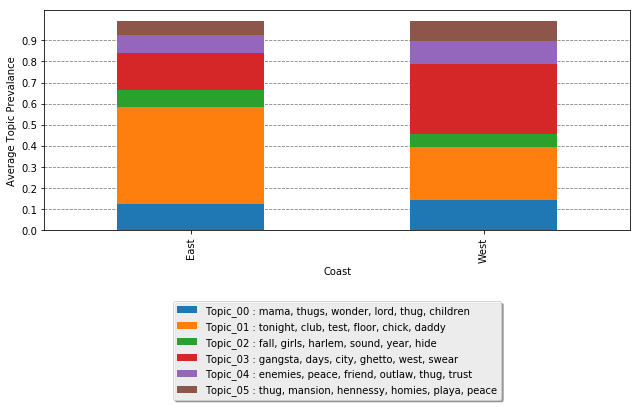

In [47]:
# First let's look at topics by COAST
visualize_average_topic_by_column(rap_df, 'Coast', lda, top_n_terms = 6)

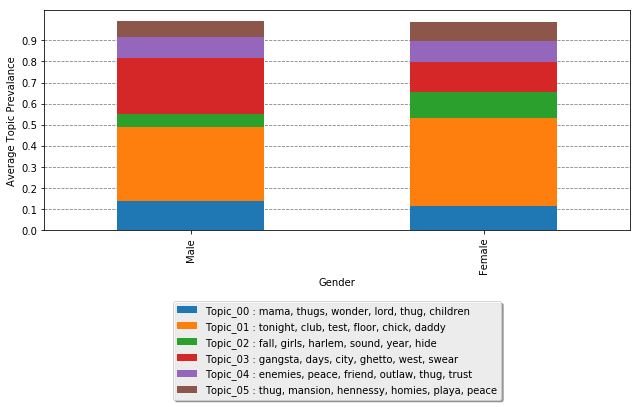

In [48]:
# And then topics by GENDER
visualize_average_topic_by_column(rap_df, 'Gender', lda, top_n_terms = 6)

# While the plots above are interesting, there is a limitaiton.  We may not always have a balance between our data categories.  Specifically in this dataset, the difference between East Coast and West Coast is fairly balanced but Gender is not.  So as as experiment, let's perform a different kind of topic modeling wherewe examine what we can surface when we train one model for each category and look at the result.
## In other words, instead of one "combined" model, we'll train one for East Coast and another for West Coast.  Then we'll do the same with one for Male and another for Female regardless of their data balance.  While these many not be comparable quantitatively, we may gain some qualitative understanding about differences in topics and structure.

In [49]:
def get_text_indices(col_name, col_value, df, index_list):
    text_index_list = []
    for i, index in enumerate(index_list):
        if df.loc[index, col_name] == col_value:
            text_index_list.append(i)
            
    return text_index_list

In [50]:
east_tokenized_text_indices = get_text_indices('Coast', 'East', rap_df, index_list)
east_corpus = Corpus([filtered_tokenized_texts[idx] for idx in east_tokenized_text_indices])

west_tokenized_text_indices = get_text_indices('Coast', 'West', rap_df, index_list)
west_corpus = Corpus([filtered_tokenized_texts[idx] for idx in west_tokenized_text_indices])

male_tokenized_text_indices = get_text_indices('Gender', 'Male', rap_df, index_list)
male_corpus = Corpus([filtered_tokenized_texts[idx] for idx in male_tokenized_text_indices])

female_tokenized_text_indices = get_text_indices('Gender', 'Female', rap_df, index_list)
female_corpus = Corpus([filtered_tokenized_texts[idx] for idx in female_tokenized_text_indices])

print('Size of East Corpus : {}'.format(len(east_corpus)))
print('Size of West Corpus : {}'.format(len(west_corpus)))
print('Size of Male Corpus : {}'.format(len(male_corpus)))
print('Size of Female Corpus : {}'.format(len(female_corpus)))

Size of East Corpus : 1157
Size of West Corpus : 1028
Size of Male Corpus : 1903
Size of Female Corpus : 282


# Now let's train the models for each category.  This will take time for each model

In [51]:
# let's reduce how much time we'll need for each model by reducing the # of topics and passes across the data
NUM_STRATIFICATION_TOPICS = 5
NUM_STRATIFICATION_PASSES = 6

In [52]:
%%time

east_corpus.dictionary = corpus.dictionary

east_lda = gensim.models.ldamodel.LdaModel(east_corpus, 
                                     id2word = east_corpus.dictionary, 
                                     num_topics = NUM_STRATIFICATION_TOPICS,
                                         passes = NUM_STRATIFICATION_PASSES)

Wall time: 9.53 s


In [53]:
%%time

west_corpus.dictionary = corpus.dictionary

west_lda = gensim.models.ldamodel.LdaModel(west_corpus, 
                                     id2word = west_corpus.dictionary, 
                                     num_topics = NUM_STRATIFICATION_TOPICS,
                                         passes = NUM_STRATIFICATION_PASSES)

Wall time: 8.41 s


In [54]:
%%time

male_corpus.dictionary = corpus.dictionary

male_lda = gensim.models.ldamodel.LdaModel(male_corpus, 
                                     id2word = male_corpus.dictionary, 
                                     num_topics = NUM_STRATIFICATION_TOPICS,
                                         passes = NUM_STRATIFICATION_PASSES)

Wall time: 17 s


In [55]:
%%time

female_corpus.dictionary = corpus.dictionary

female_lda = gensim.models.ldamodel.LdaModel(female_corpus, 
                                     id2word = female_corpus.dictionary, 
                                     num_topics = NUM_STRATIFICATION_TOPICS,
                                         passes = NUM_STRATIFICATION_PASSES)

Wall time: 1.69 s


In [56]:
print('West Coast lyrics topics : ')
pyLDAvis.display(gensim_prepare(west_lda, west_corpus, west_corpus.dictionary))

West Coast lyrics topics : 


In [57]:
print('East Coast lyrics topics : ')
pyLDAvis.display(gensim_prepare(east_lda, east_corpus, east_corpus.dictionary))

East Coast lyrics topics : 


In [58]:
print('Female lyrics topics : ')
pyLDAvis.display(gensim_prepare(female_lda, female_corpus, female_corpus.dictionary))

Female lyrics topics : 


In [59]:
print('Male lyrics topics : ')
pyLDAvis.display(gensim_prepare(male_lda, male_corpus, male_corpus.dictionary))

Male lyrics topics : 


# We've now just scratched the surface on what we can do with topic models to help us quickly understand a large body of text and see it in different ways.  Here are some of the other questions one might ask in this dataset:
* What do topics look like for other rap artists who were not part of the East/West coast rivalry?
* What different topics exist between musical genres like Rap, Country, Metal, etc?
* Which genres have the most diversity or complexity in their topics?
* Which artists seem to have the most varied topics in their lyrics?
* How does preprocessing impact our results?
* What happens if we do not filter nouns?
* What happens if we do not filter stopwords?
* What kinds of terms do we see if we allow non-alphabetic characters?

# There are a lot of very interesting papers using topic modeling.  Not all of them use text.  Here are a few very interesting examples of interesting research:
* [Individuals, Institutions, and Innovation in the Debates of the French Revolution](https://arxiv.org/abs/1710.06867)
* [Topic and role discovery in social networks with experiments on enron and academic email](https://www.jair.org/index.php/jair/article/view/10515/25186)
* [Modeling musical influence with topic models](http://proceedings.mlr.press/v28/shalit13.pdf)
* [Discovering scientific influence using cross-domain dynamic topic modeling](https://ebiquity.umbc.edu/get/a/publication/873.pdf)